In [1]:
cd /home/chenxupeng/projects/practice

/home/chenxupeng/projects/practice


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
from tqdm import tqdm
import keras
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
%pylab inline
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


导入示例数据
X: images_train  每张图为128*128的16通道图像，像素值为0或1

In [3]:
with h5py.File('deepshapedata_100') as f:
    images_train = f['images_train'][:]
    y_train=f['y_train'][:]
y_train = np.concatenate([y_train,y_train],axis = 1)
print images_train.shape
print y_train.shape    #为了实现特殊设计，把y重复了一遍

(100, 128, 128, 16)
(100, 256)


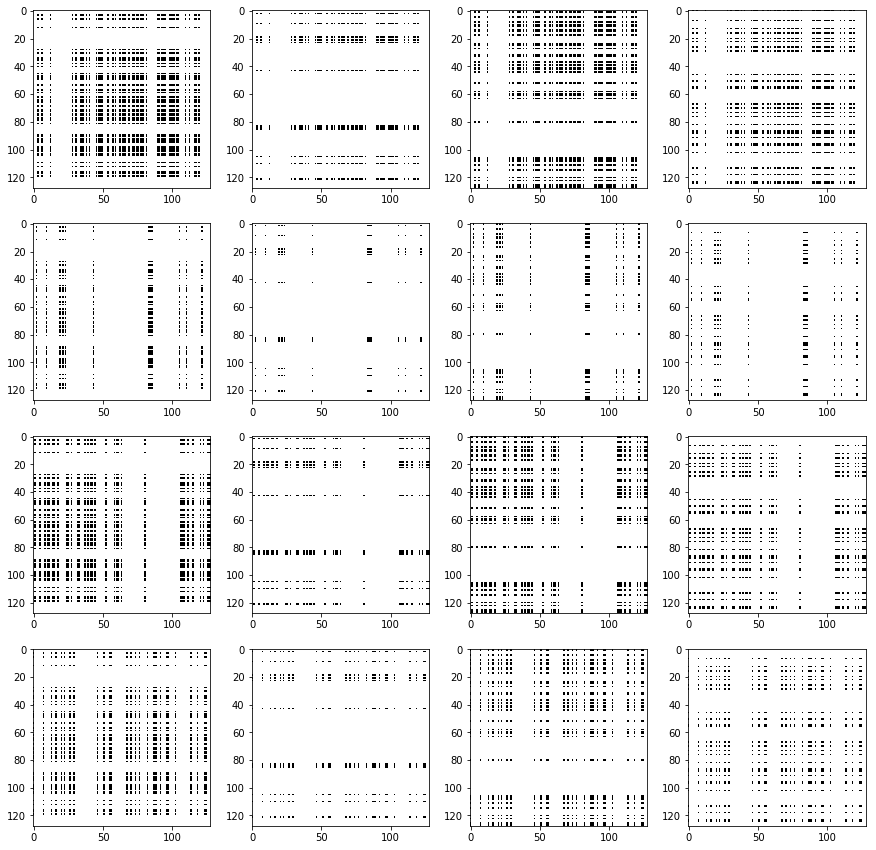

In [4]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images_train[0][:,:,4*i+j],cmap=cm.Greys)

导入Keras的Model来建立模型，从layers模块导入卷积、池化、批规范化、激活函数等

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout, Activation,Reshape
from keras.layers.merge import concatenate
from keras.layers import Lambda, Dot


# deepshape数据为16通道，即每张图的shape为128*128*16
INPUT_CHANNELS = 16
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1

def double_conv_layer(x, size, dropout, batch_norm):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    return conv

dropout_val = 0.2
def UNET_128(dropout_val=dropout_val, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 128,128))
        axis = 1
    else:
        inputs = Input((128, 128, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_128 = double_conv_layer(inputs, filters, dropout_val, batch_norm)
    pool_64 = MaxPooling2D(pool_size=(2, 2))(conv_128)

    conv_64 = double_conv_layer(pool_64, 2*filters, dropout_val, batch_norm)
    pool_32 = MaxPooling2D(pool_size=(2, 2))(conv_64)

    conv_32 = double_conv_layer(pool_32, 4*filters, dropout_val, batch_norm)
    pool_16 = MaxPooling2D(pool_size=(2, 2))(conv_32)

    conv_16 = double_conv_layer(pool_16, 8*filters, dropout_val, batch_norm)
    pool_8 = MaxPooling2D(pool_size=(2, 2))(conv_16)

    conv_8 = double_conv_layer(pool_8, 16*filters, dropout_val, batch_norm)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_8)

    conv_4 = double_conv_layer(pool_4, 32*filters, dropout_val, batch_norm)

    up_8 = concatenate([UpSampling2D(size=(2, 2))(conv_4), conv_8], axis=axis)
    up_conv_8 = double_conv_layer(up_8, 16*filters, dropout_val, batch_norm)

    up_16 = concatenate([UpSampling2D(size=(2, 2))(up_conv_8), conv_16], axis=axis)
    up_conv_16 = double_conv_layer(up_16, 8*filters, dropout_val, batch_norm)

    up_32 = concatenate([UpSampling2D(size=(2, 2))(up_conv_16), conv_32], axis=axis)
    up_conv_32 = double_conv_layer(up_32, 4*filters, dropout_val, batch_norm)

    up_64 = concatenate([UpSampling2D(size=(2, 2))(up_conv_32), conv_64], axis=axis)
    up_conv_64 = double_conv_layer(up_64, 2*filters, dropout_val, batch_norm)

    up_128 = concatenate([UpSampling2D(size=(2, 2))(up_conv_64), conv_128], axis=axis)
    up_conv_128 = double_conv_layer(up_128, filters, 0, batch_norm)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_128)
    conv_final = BatchNormalization(axis=axis)(conv_final)
    conv_final = Activation('sigmoid')(conv_final)

    final = Lambda(lambda x: K.sum(x, axis=1), output_shape=(128,))(conv_final)
    #sum by columns output a vector of 128 elements
    final_ = Reshape((128,), input_shape=(128,1))(final)
    final =Lambda(lambda x: x/128.0, output_shape=(128,))(final_)

    model = Model(inputs, final, name="ZF_UNET_128")
    return model

In [6]:
def binary_crossentropy_with_nan(y_true, y_pred):
    not_nan = tf.logical_not(tf.is_nan(y_true))
    y_true = tf.boolean_mask(y_true, not_nan)
    y_pred = tf.boolean_mask(y_pred, not_nan)
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=-1)

#define new loss using output layer and hidden layer
class CrossEntropyLoss(object):
    def __init__(self, model,alpha):
        self.layer = model.get_layer(index = -8).output
        self.__name__ = 'CrossEntropyLoss'
        self.alpha = alpha
    def __call__(self,y_true, y_pred):
        return binary_crossentropy_with_nan(y_true, y_pred) + self.alpha * mean_squared_error(self.layer,tf.transpose(self.layer, perm=[0, 2, 1, 3]))

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)
    
class MSE(object):
    def __init__(self, model):
        self.layer = model.get_layer(index = -8).output
        self.__name__ = 'MSE'
    def __call__(self,y_true,y_pred):
        return mean_squared_error(self.layer,tf.transpose(self.layer, perm=[0, 2, 1, 3]))


def binary_accuracy_with_nan(y_true, y_pred):
    not_nan = tf.logical_not(tf.is_nan(y_true))
    y_true = tf.boolean_mask(y_true, not_nan)
    y_pred = tf.boolean_mask(y_pred, not_nan)
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)
keras.metrics.binary_accuracy_with_nan = binary_accuracy_with_nan

In [7]:
model = UNET_128()
optim = Adam()
model.compile(optimizer=optim, loss=CrossEntropyLoss(model,10), metrics=[binary_accuracy_with_nan,binary_crossentropy_with_nan,MSE(model)])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 16) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4640        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
def Model(images_train,y_train,cv,seq_counts):
    model.fit(images_train, y_train, batch_size=32, nb_epoch=20,
              verbose=1, shuffle=True,validation_split=0.2)        
    #model.save('output/newunet_row_col_mse.hdf5')

In [9]:
for i in range(1):
    Model(images_train[:,:,:,:],y_train[:,:],i,number)

Train on 80 samples, validate on 20 samples
Epoch 1/20
80/80 [==============================] - 6s 77ms/step - loss: 26.5516 - binary_accuracy_with_nan: 0.4793 - binary_crossentropy_with_nan: 8.2355 - MSE: 1.8316 - val_loss: 3041561.5000 - val_binary_accuracy_with_nan: 0.4205 - val_binary_crossentropy_with_nan: 8.5482 - val_MSE: 304155.2812
Epoch 2/20
80/80 [==============================] - 1s 11ms/step - loss: 17.1269 - binary_accuracy_with_nan: 0.5329 - binary_crossentropy_with_nan: 7.7247 - MSE: 0.9402 - val_loss: 204406.8906 - val_binary_accuracy_with_nan: 0.4159 - val_binary_crossentropy_with_nan: 8.9451 - val_MSE: 20439.7871
Epoch 3/20
80/80 [==============================] - 1s 10ms/step - loss: 10.1186 - binary_accuracy_with_nan: 0.4953 - binary_crossentropy_with_nan: 8.1113 - MSE: 0.2007 - val_loss: 244768.7188 - val_binary_accuracy_with_nan: 0.4295 - val_binary_crossentropy_with_nan: 8.9309 - val_MSE: 24475.9824
Epoch 4/20
80/80 [==============================] - 1s 10ms/ste

In [10]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
# Testing
layer_outs = functor([images_train[90:], 1.])

In [11]:
len(layer_outs)

98

In [12]:
for i in range(98):
    print layer_outs[i].shape

(10, 128, 128, 16)
(10, 128, 128, 32)
(10, 128, 128, 32)
(10, 128, 128, 32)
(10, 128, 128, 32)
(10, 128, 128, 32)
(10, 128, 128, 32)
(10, 128, 128, 32)
(10, 64, 64, 32)
(10, 64, 64, 64)
(10, 64, 64, 64)
(10, 64, 64, 64)
(10, 64, 64, 64)
(10, 64, 64, 64)
(10, 64, 64, 64)
(10, 64, 64, 64)
(10, 32, 32, 64)
(10, 32, 32, 128)
(10, 32, 32, 128)
(10, 32, 32, 128)
(10, 32, 32, 128)
(10, 32, 32, 128)
(10, 32, 32, 128)
(10, 32, 32, 128)
(10, 16, 16, 128)
(10, 16, 16, 256)
(10, 16, 16, 256)
(10, 16, 16, 256)
(10, 16, 16, 256)
(10, 16, 16, 256)
(10, 16, 16, 256)
(10, 16, 16, 256)
(10, 8, 8, 256)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 4, 4, 512)
(10, 4, 4, 1024)
(10, 4, 4, 1024)
(10, 4, 4, 1024)
(10, 4, 4, 1024)
(10, 4, 4, 1024)
(10, 4, 4, 1024)
(10, 4, 4, 1024)
(10, 8, 8, 1024)
(10, 8, 8, 1536)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 8, 8, 512)
(10, 16, 16, 512

In [13]:
print layer_outs[91].shape

(10, 128, 128, 32)


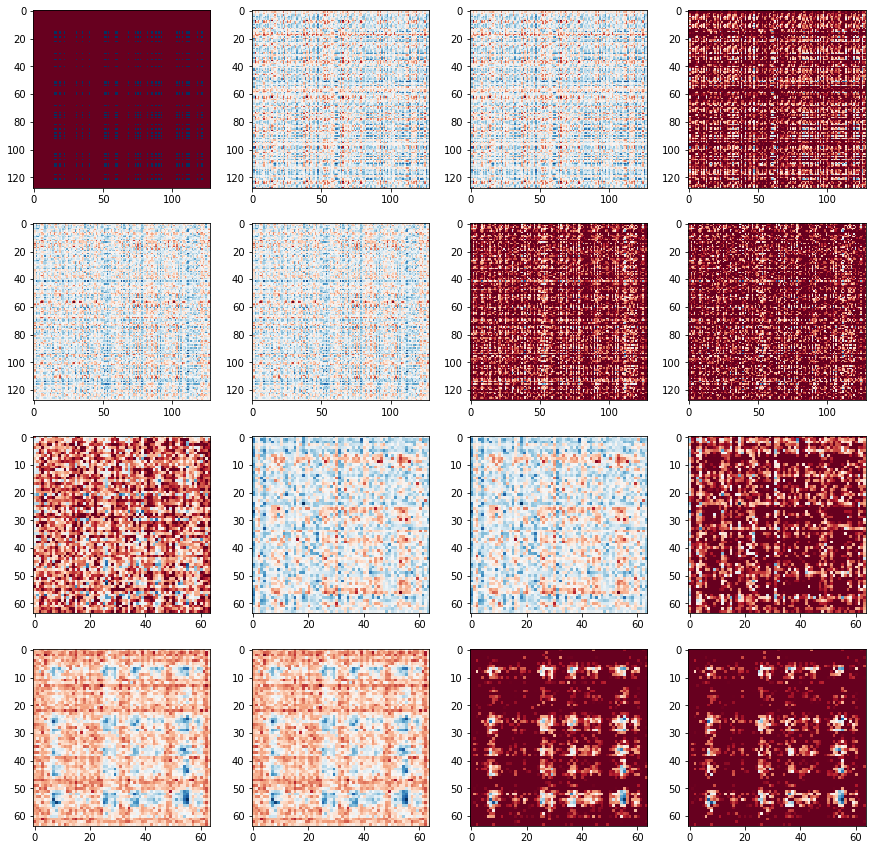

In [25]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(layer_outs[4*i+j][0,:,:,0],cmap=cm.RdBu)